# KETARA Chatbot - LSTM Implementation
## Chatbot untuk Informasi ITERA menggunakan Deep Learning (LSTM)

Notebook ini mendemonstrasikan implementasi chatbot berbasis LSTM untuk menjawab pertanyaan seputar kampus ITERA.

### 🔧 Optimasi Model (Updated)

**Perubahan dari versi sebelumnya:**

| Parameter | Sebelum | Sesudah | Alasan |
|-----------|---------|---------|--------|
| Embedding Dim | 128 | 64 | Dataset kecil, vocabulary terbatas |
| LSTM Units | 128 | 64 | Mencegah overfitting |
| Dense Units | 64 | 32 | Model lebih sederhana |
| Dropout Rate | 0.5 | 0.3 | Dataset kecil butuh lebih banyak learning |
| Batch Size | 8 | 4 | Update gradient lebih sering |
| Max Epochs | 100 | 200 | Dataset kecil butuh lebih banyak iterasi |
| Validation Split | 0.2 | 0.15 | Maksimalkan training data |
| Patience | 15 | 25 | Lebih toleran terhadap fluktuasi |

**Tambahan:**
- ✅ Data Augmentation untuk menambah variasi patterns
- ✅ ReduceLROnPlateau untuk adaptive learning rate
- ✅ Format model .keras (recommended)

### Arsitektur Model:

1. **Embedding Layer (64 dimensi)** - Word representation
2. **Bidirectional LSTM (64 units)** - Context dari 2 arah  
3. **Bidirectional LSTM (32 units)** - Deep representation
4. **Dense Layer (32 units)** - Feature extraction
5. **Softmax Output** - Multi-class classification

---

## 1. Import Libraries

In [1]:
import json
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import re

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


2025-11-16 11:39:52.411855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!


## 2. Load dan Eksplorasi Dataset

In [2]:
# Load dataset
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

print(f"Total intents: {len(data)}\n")

# Tampilkan struktur data
for i, intent in enumerate(data, 1):
    print(f"{i}. Tag: {intent['tag']}")
    print(f"   Jumlah patterns: {len(intent['patterns'])}")
    print(f"   Jumlah responses: {len(intent['responses'])}")
    print(f"   Contoh pattern: {intent['patterns'][0]}")
    print()


Total intents: 117

1. Tag: tentang_itera
   Jumlah patterns: 19
   Jumlah responses: 1
   Contoh pattern: Apa itu ITERA?

2. Tag: lokasi_itera
   Jumlah patterns: 10
   Jumlah responses: 1
   Contoh pattern: Dimana lokasi ITERA?

3. Tag: luas_kampus
   Jumlah patterns: 6
   Jumlah responses: 1
   Contoh pattern: Berapa luas kampus ITERA?

4. Tag: visi_misi
   Jumlah patterns: 7
   Jumlah responses: 1
   Contoh pattern: Visi ITERA apa?

5. Tag: fakultas_itera
   Jumlah patterns: 8
   Jumlah responses: 1
   Contoh pattern: Fakultas apa saja yang ada di ITERA?

6. Tag: fasilitas_itera
   Jumlah patterns: 5
   Jumlah responses: 1
   Contoh pattern: Apa saja fasilitas di ITERA?

7. Tag: plts_energi
   Jumlah patterns: 7
   Jumlah responses: 1
   Contoh pattern: Apa itu PLTS ITERA?

8. Tag: kebun_raya
   Jumlah patterns: 7
   Jumlah responses: 1
   Contoh pattern: Apa itu Kebun Raya ITERA?

9. Tag: akreditasi_prestasi
   Jumlah patterns: 6
   Jumlah responses: 1
   Contoh pattern: Akreditas

## 3. Preprocessing Data

In [3]:
def preprocess_text(text):
    """Preprocessing text"""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = ' '.join(text.split())
    return text

# Extract patterns dan tags
patterns = []
tags = []
responses_dict = {}

for intent in data:
    tag = intent['tag']
    responses_dict[tag] = intent['responses']
    
    for pattern in intent['patterns']:
        cleaned_pattern = preprocess_text(pattern)
        patterns.append(cleaned_pattern)
        tags.append(tag)

print(f"Total patterns: {len(patterns)}")
print(f"Unique tags: {len(set(tags))}")
print(f"\nContoh preprocessing:")
print(f"Original: {data[0]['patterns'][0]}")
print(f"Preprocessed: {patterns[0]}")


Total patterns: 700
Unique tags: 117

Contoh preprocessing:
Original: Apa itu ITERA?
Preprocessed: apa itu itera


In [4]:
# Data Augmentation - menambah variasi patterns
def augment_patterns(patterns, tags):
    """
    Augmentasi data dengan menambah variasi patterns
    """
    augmented_patterns = patterns.copy()
    augmented_tags = tags.copy()
    
    # Variasi pertanyaan untuk augmentasi
    augmentation_rules = {
        'apa': ['apakah', 'apa itu', 'apa sih'],
        'dimana': ['di mana', 'lokasi', 'tempat'],
        'bagaimana': ['gimana', 'seperti apa'],
        'ceritakan': ['jelaskan', 'beritahu', 'informasi'],
        'itera': ['institut teknologi sumatera', 'kampus itera'],
    }
    
    # Tambahkan augmented patterns
    for i, (pattern, tag) in enumerate(zip(patterns, tags)):
        words = pattern.split()
        
        # Augmentasi 1: Tambah "yang" atau "adalah"
        if len(words) >= 3:
            aug_pattern = ' '.join(words) + ' yang dimaksud'
            augmented_patterns.append(aug_pattern)
            augmented_tags.append(tag)
        
        # Augmentasi 2: Variasi kata tanya
        for old_word, variations in augmentation_rules.items():
            if old_word in pattern:
                for variation in variations:
                    aug_pattern = pattern.replace(old_word, variation)
                    if aug_pattern != pattern:  # Pastikan berbeda
                        augmented_patterns.append(aug_pattern)
                        augmented_tags.append(tag)
    
    return augmented_patterns, augmented_tags

# Terapkan augmentasi
original_count = len(patterns)
patterns_augmented, tags_augmented = augment_patterns(patterns, tags)

print(f"Original patterns: {original_count}")
print(f"Augmented patterns: {len(patterns_augmented)}")
print(f"Increase: +{len(patterns_augmented) - original_count} patterns ({((len(patterns_augmented) - original_count) / original_count * 100):.1f}% increase)")
print(f"\nContoh augmentasi:")
print(f"Original: {patterns[0]}")
print(f"Augmented examples:")
for i, (pat, tag) in enumerate(zip(patterns_augmented[-5:], tags_augmented[-5:])):
    print(f"  {i+1}. {pat} -> {tag}")

# Update patterns dan tags dengan yang sudah diaugmentasi
patterns = patterns_augmented
tags = tags_augmented


Original patterns: 700
Augmented patterns: 2606
Increase: +1906 patterns (272.3% increase)

Contoh augmentasi:
Original: apa itu itera
Augmented examples:
  1. penerbitan buku institut teknologi sumatera -> penerbit_itera
  2. penerbitan buku kampus itera -> penerbit_itera
  3. bunga rampai ai yang dimaksud -> penerbit_itera
  4. linstitut teknologi sumaterasi penerbitan -> penerbit_itera
  5. lkampus iterasi penerbitan -> penerbit_itera


### Data Augmentation untuk Meningkatkan Dataset

Karena dataset kecil (~30 patterns), kita akan augmentasi data dengan:
1. Menambah variasi pertanyaan
2. Synonym replacement
3. Word order variation


## 4. Tokenization dan Encoding

In [5]:
# Tokenization
tokenizer = Tokenizer(lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(patterns)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")
print(f"\nTop 10 words in vocabulary:")
for word, idx in list(tokenizer.word_index.items())[:10]:
    print(f"  {word}: {idx}")

# Convert to sequences
sequences = tokenizer.texts_to_sequences(patterns)
print(f"\nContoh sequence: {sequences[0]}")
print(f"Original text: {patterns[0]}")

# Pad sequences
max_sequence_length = 20
X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
print(f"\nShape setelah padding: {X.shape}")
print(f"Contoh padded sequence: {X[0]}")


Vocabulary size: 681

Top 10 words in vocabulary:
  <OOV>: 1
  itera: 2
  kampus: 3
  yang: 4
  teknologi: 5
  sumatera: 6
  institut: 7
  dimaksud: 8
  apa: 9
  di: 10

Contoh sequence: [9, 13, 2]
Original text: apa itu itera

Shape setelah padding: (2606, 20)
Contoh padded sequence: [ 9 13  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [11]:
print(X)


[[  9  13   2 ...   0   0   0]
 [164  72   2 ...   0   0   0]
 [263 311   2 ...   0   0   0]
 ...
 [607 608 275 ...   0   0   0]
 [307   5 308 ...   0   0   0]
 [309 310 262 ...   0   0   0]]


In [6]:
# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(tags)
y_encoded = label_encoder.transform(tags)
num_classes = len(label_encoder.classes_)
y = to_categorical(y_encoded, num_classes=num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"\nOutput shape: {y.shape}")
print(f"\nContoh label encoding:")
print(f"Tag: {tags[0]}")
print(f"Encoded: {y_encoded[0]}")
print(f"One-hot: {y[0]}")


Number of classes: 117
Classes: ['air_tanah_geofisika' 'akreditasi_prestasi' 'akreditasi_prodi' 'alumni'
 'animasi_3d_budaya' 'arsitektur_itera' 'asal_mahasiswa' 'asrama'
 'bahasa_inggris' 'beasiswa' 'berita_terbaru_itera' 'biaya_pendidikan'
 'biogas_energi' 'biologi_itera' 'biomedis_inovasi' 'budaya_ukm'
 'dashboard_itera' 'data_center_industri' 'data_dosen' 'data_mahasiswa'
 'data_tendik' 'desain_komunikasi_visual' 'dies_natalis' 'dim_itera'
 'dosen_berdampak' 'duta_itera' 'ecoprint_seni' 'embung' 'fakultas_itera'
 'farmasi_itera' 'fasilitas_ibadah' 'fasilitas_itera'
 'fasilitas_penunjang' 'fisika_itera' 'fisika_kuantum' 'gedung_fasilitas'
 'geomatika_itera' 'goodbye' 'greeting' 'ijazah_digital'
 'inkubator_bisnis' 'inovasi_pangan' 'jalur_masuk' 'kampus_berdampak_mbkm'
 'kampus_hijau' 'kantin_kontainer' 'kantin_makan' 'kebun_raya'
 'kegiatan_akademik' 'kepemimpinan_transformasional' 'kerjasama'
 'kerjasama_internasional' 'kesehatan' 'kesehatan_mental_mahasiswa'
 'kesehatan_reproduksi

## 5. Visualisasi Distribusi Data

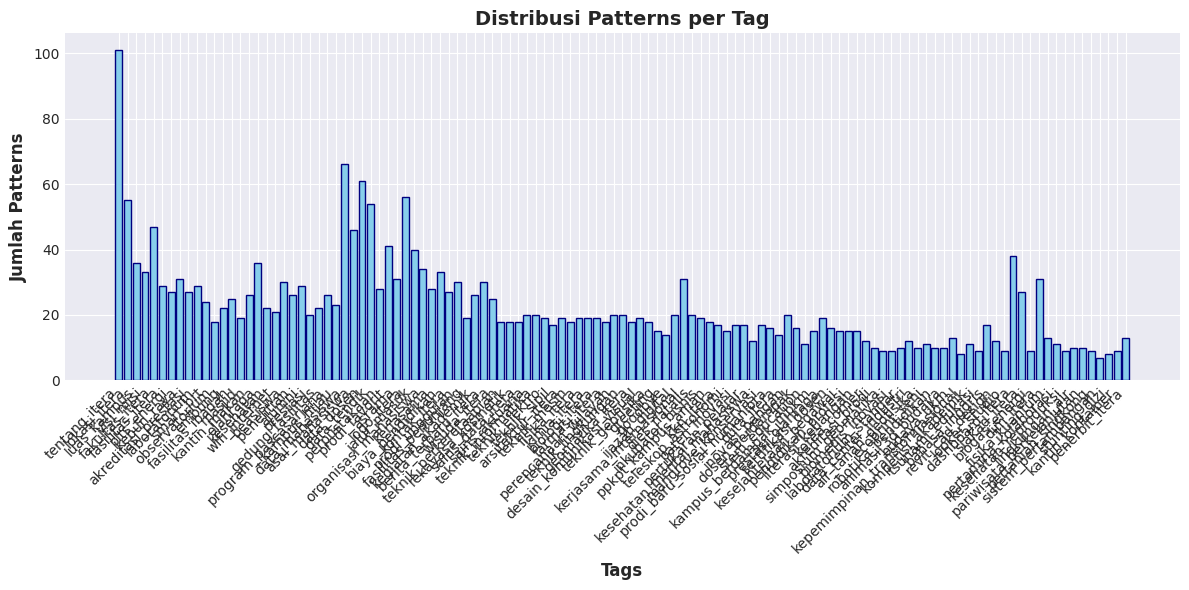


Distribusi patterns per tag:
  tentang_itera: 101 patterns
  lokasi_itera: 55 patterns
  luas_kampus: 36 patterns
  visi_misi: 33 patterns
  fakultas_itera: 47 patterns
  fasilitas_itera: 29 patterns
  plts_energi: 27 patterns
  kebun_raya: 31 patterns
  akreditasi_prestasi: 27 patterns
  laboratorium: 29 patterns
  smart_brt: 24 patterns
  observatorium: 18 patterns
  embung: 22 patterns
  fasilitas_ibadah: 25 patterns
  masjid: 19 patterns
  kantin_makan: 26 patterns
  olahraga: 36 patterns
  kesehatan: 22 patterns
  wifi_internet: 21 patterns
  beasiswa: 30 patterns
  penelitian: 26 patterns
  alumni: 29 patterns
  prestasi: 20 patterns
  gedung_fasilitas: 22 patterns
  program_pascasarjana: 26 patterns
  kampus_hijau: 23 patterns
  data_mahasiswa: 66 patterns
  asal_mahasiswa: 46 patterns
  data_dosen: 61 patterns
  data_tendik: 54 patterns
  perpustakaan: 28 patterns
  prodi_favorit: 41 patterns
  asrama: 31 patterns
  logo_itera: 56 patterns
  jalur_masuk: 40 patterns
  organisa

In [7]:
# Visualisasi distribusi patterns per tag
from collections import Counter

tag_counts = Counter(tags)

plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue', edgecolor='navy')
plt.xlabel('Tags', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Patterns', fontsize=12, fontweight='bold')
plt.title('Distribusi Patterns per Tag', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nDistribusi patterns per tag:")
for tag, count in tag_counts.items():
    print(f"  {tag}: {count} patterns")


## 6. Membangun Arsitektur LSTM

### Penjelasan Arsitektur:

1. **Embedding Layer (128 dimensi)**
   - Mengubah token menjadi dense vector representation
   - Setiap kata direpresentasikan dalam 128 dimensi

2. **Bidirectional LSTM Layer 1 (128 units)**
   - Memproses sequence dari kiri ke kanan dan kanan ke kiri
   - Return sequences=True untuk stack LSTM berikutnya
   - Dropout 0.5 dan recurrent dropout 0.2 untuk mencegah overfitting

3. **Bidirectional LSTM Layer 2 (64 units)**
   - Layer LSTM kedua untuk menangkap context lebih dalam
   - Return sequences=False karena ini layer terakhir

4. **Dropout Layer (0.5)**
   - Regularization untuk mencegah overfitting

5. **Dense Layer (64 units, ReLU)**
   - Fully connected layer untuk feature extraction

6. **Output Layer (Softmax)**
   - Multi-class classification
   - Output probabilitas untuk setiap intent/tag

In [8]:
# Hyperparameters - Optimized untuk dataset kecil
EMBEDDING_DIM = 64 
LSTM_UNITS = 64     
DROPOUT_RATE = 0.3  


# Build model
model = Sequential([
    # Embedding Layer 
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=max_sequence_length,
        name='embedding_layer'
    ),
    
    # Bidirectional LSTM Layer 1
    Bidirectional(LSTM(
        units=LSTM_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE,
        recurrent_dropout=0.2
    ), name='bidirectional_lstm_1'),
    
    # Bidirectional LSTM Layer 2 
    Bidirectional(LSTM(
        units=LSTM_UNITS // 2,
        return_sequences=False,
        dropout=DROPOUT_RATE,
        recurrent_dropout=0.2
    ), name='bidirectional_lstm_2'),
    
    # Dropout Layer
    Dropout(DROPOUT_RATE, name='dropout_layer'),
    
    # Dense Layer 
    Dense(32, activation='relu', name='dense_1'),
    Dropout(DROPOUT_RATE / 2, name='dropout_2'),
    
    # Output Layer
    Dense(num_classes, activation='softmax', name='output_layer')
])


from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.build(input_shape=(None, max_sequence_length))

print("\nModel Architecture:")
model.summary()
print(f"\nTotal Parameters: {model.count_params():,}")


/home/leccaz/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1763267996.797438    1098 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 20, 64)         │        43,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 20, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 117)            │         3,861 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,789 (612.46 KB)

 Trainable params: 156,789 (612.46 KB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 156,789


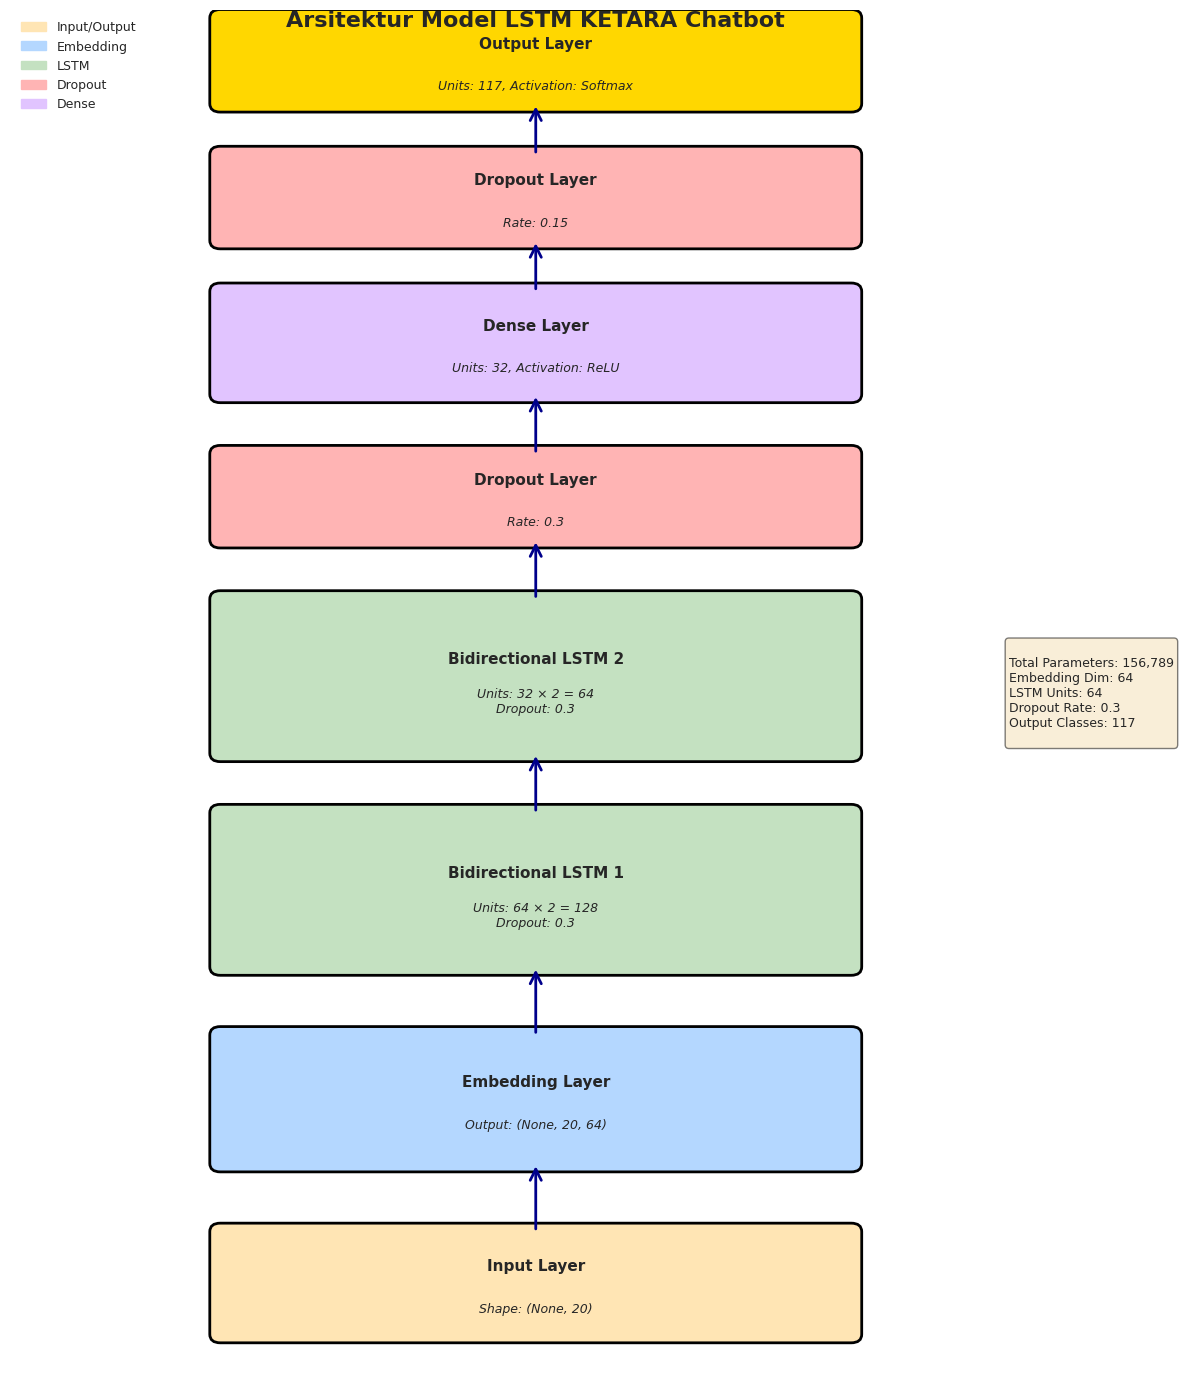

Visualisasi arsitektur model berhasil dibuat!


In [12]:
# Visualisasi Arsitektur Model
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(12, 14))
ax.set_xlim(0, 10)
ax.set_ylim(0, 16)
ax.axis('off')

# Fungsi untuk membuat box layer
def create_layer_box(ax, x, y, width, height, text, color, detail_text=""):
    box = FancyBboxPatch((x, y), width, height, 
                         boxstyle="round,pad=0.1", 
                         edgecolor='black', 
                         facecolor=color, 
                         linewidth=2)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2 + 0.2, text, 
           ha='center', va='center', fontsize=11, fontweight='bold')
    if detail_text:
        ax.text(x + width/2, y + height/2 - 0.3, detail_text, 
               ha='center', va='center', fontsize=9, style='italic')

# Fungsi untuk membuat panah
def create_arrow(ax, x1, y1, x2, y2):
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                           arrowstyle='->', mutation_scale=20, 
                           linewidth=2, color='darkblue')
    ax.add_patch(arrow)

# Layer positions (dari bawah ke atas)
layers = [
    # (x, y, width, height, name, color, detail)
    (2, 0.5, 6, 1.2, "Input Layer", "#FFE5B4", f"Shape: (None, {max_sequence_length})"),
    (2, 2.5, 6, 1.5, "Embedding Layer", "#B4D7FF", f"Output: (None, {max_sequence_length}, {EMBEDDING_DIM})"),
    (2, 4.8, 6, 1.8, "Bidirectional LSTM 1", "#C4E1C1", f"Units: {LSTM_UNITS} × 2 = {LSTM_UNITS*2}\nDropout: {DROPOUT_RATE}"),
    (2, 7.3, 6, 1.8, "Bidirectional LSTM 2", "#C4E1C1", f"Units: {LSTM_UNITS//2} × 2 = {LSTM_UNITS}\nDropout: {DROPOUT_RATE}"),
    (2, 9.8, 6, 1.0, "Dropout Layer", "#FFB4B4", f"Rate: {DROPOUT_RATE}"),
    (2, 11.5, 6, 1.2, "Dense Layer", "#E1C4FF", f"Units: 32, Activation: ReLU"),
    (2, 13.3, 6, 1.0, "Dropout Layer", "#FFB4B4", f"Rate: {DROPOUT_RATE/2:.2f}"),
    (2, 14.9, 6, 1.0, "Output Layer", "#FFD700", f"Units: {num_classes}, Activation: Softmax")
]

# Draw layers
for layer in layers:
    create_layer_box(ax, *layer)

# Draw arrows
arrow_positions = [
    (5, 1.7, 5, 2.5),   # Input -> Embedding
    (5, 4.0, 5, 4.8),   # Embedding -> BiLSTM1
    (5, 6.6, 5, 7.3),   # BiLSTM1 -> BiLSTM2
    (5, 9.1, 5, 9.8),   # BiLSTM2 -> Dropout
    (5, 10.8, 5, 11.5), # Dropout -> Dense
    (5, 12.7, 5, 13.3), # Dense -> Dropout
    (5, 14.3, 5, 14.9)  # Dropout -> Output
]

for arrow_pos in arrow_positions:
    create_arrow(ax, *arrow_pos)

# Add title
ax.text(5, 15.8, 'Arsitektur Model LSTM KETARA Chatbot', 
       ha='center', fontsize=16, fontweight='bold')

# Add parameter info
param_text = f"""
Total Parameters: {model.count_params():,}
Embedding Dim: {EMBEDDING_DIM}
LSTM Units: {LSTM_UNITS}
Dropout Rate: {DROPOUT_RATE}
Output Classes: {num_classes}
"""
ax.text(9.5, 8, param_text, ha='left', va='center', 
       fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Add legend
legend_elements = [
    mpatches.Patch(color='#FFE5B4', label='Input/Output'),
    mpatches.Patch(color='#B4D7FF', label='Embedding'),
    mpatches.Patch(color='#C4E1C1', label='LSTM'),
    mpatches.Patch(color='#FFB4B4', label='Dropout'),
    mpatches.Patch(color='#E1C4FF', label='Dense'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print("Visualisasi arsitektur model berhasil dibuat!")


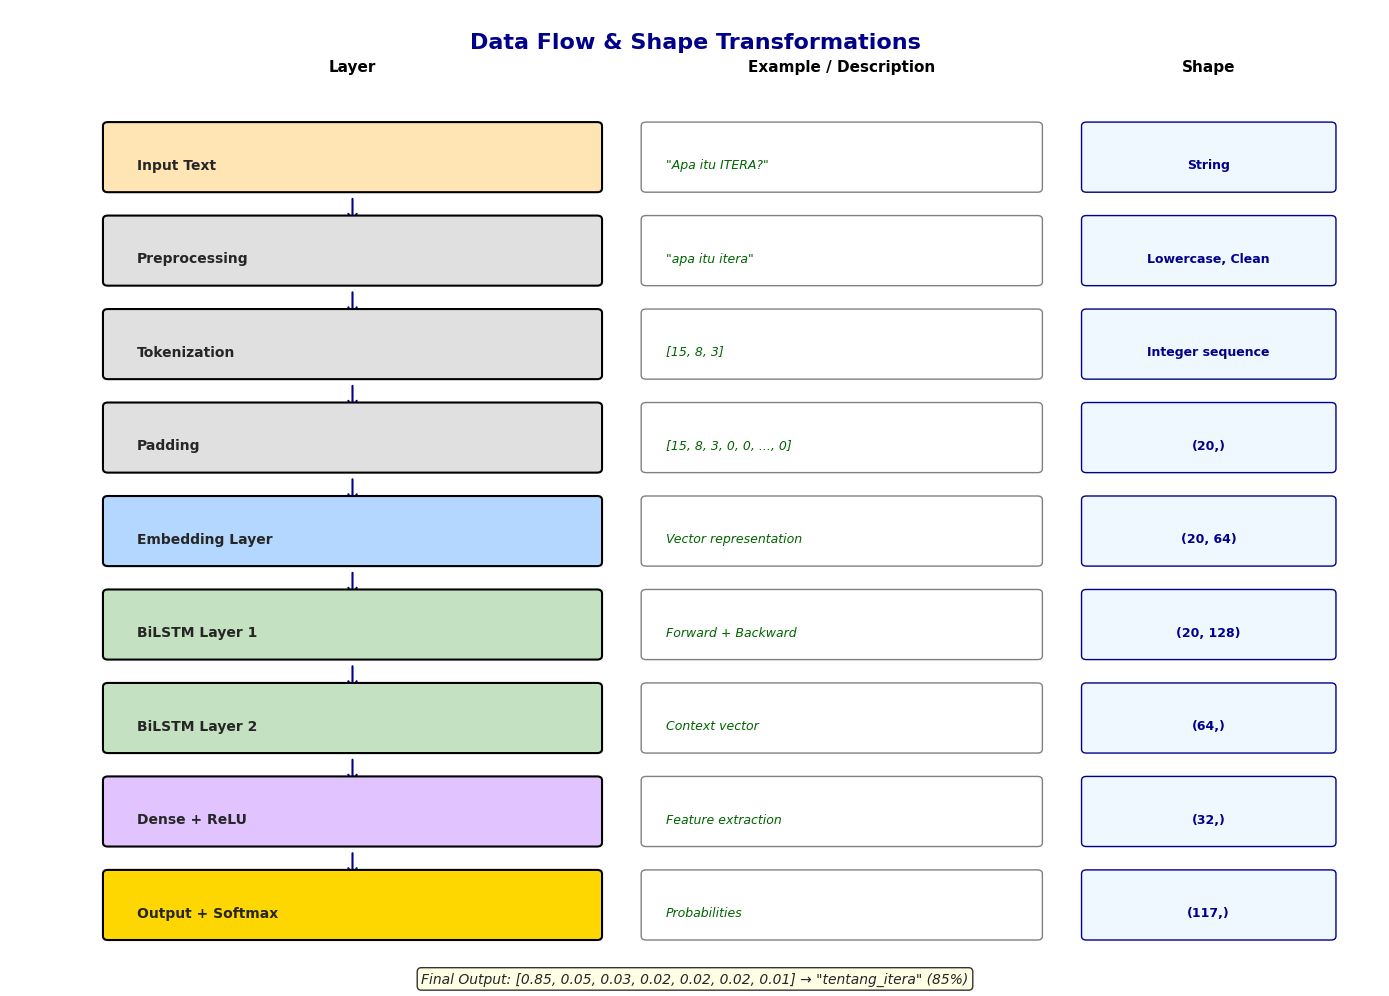


DETAIL TRANSFORMASI DATA
1. Input        : Text string
2. Preprocessing: Lowercase, clean special chars
3. Tokenization : Text → Integer indices
4. Padding      : Fixed length 20
5. Embedding    : 20 × 64 matrix
6. BiLSTM 1     : 20 × 128 (bidirectional)
7. BiLSTM 2     : 64 single vector (last output)
8. Dense        : 32 features
9. Output       : 117 probabilities


In [15]:
# Visualisasi Detail: Data Flow & Shape Transformations
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 14)
ax.set_ylim(0, 12)
ax.axis('off')

# Title
ax.text(7, 11.5, 'Data Flow & Shape Transformations', 
       ha='center', fontsize=16, fontweight='bold', color='darkblue')

# Layer information dengan shape details
layers_info = [
    {
        'name': 'Input Text',
        'example': '"Apa itu ITERA?"',
        'shape': 'String',
        'y': 10,
        'color': '#FFE5B4'
    },
    {
        'name': 'Preprocessing',
        'example': '"apa itu itera"',
        'shape': 'Lowercase, Clean',
        'y': 8.8,
        'color': '#E0E0E0'
    },
    {
        'name': 'Tokenization',
        'example': '[15, 8, 3]',
        'shape': 'Integer sequence',
        'y': 7.6,
        'color': '#E0E0E0'
    },
    {
        'name': 'Padding',
        'example': '[15, 8, 3, 0, 0, ..., 0]',
        'shape': f'({max_sequence_length},)',
        'y': 6.4,
        'color': '#E0E0E0'
    },
    {
        'name': 'Embedding Layer',
        'example': f'Vector representation',
        'shape': f'({max_sequence_length}, {EMBEDDING_DIM})',
        'y': 5.2,
        'color': '#B4D7FF'
    },
    {
        'name': 'BiLSTM Layer 1',
        'example': 'Forward + Backward',
        'shape': f'({max_sequence_length}, {LSTM_UNITS*2})',
        'y': 4.0,
        'color': '#C4E1C1'
    },
    {
        'name': 'BiLSTM Layer 2',
        'example': 'Context vector',
        'shape': f'({LSTM_UNITS},)',
        'y': 2.8,
        'color': '#C4E1C1'
    },
    {
        'name': 'Dense + ReLU',
        'example': 'Feature extraction',
        'shape': '(32,)',
        'y': 1.6,
        'color': '#E1C4FF'
    },
    {
        'name': 'Output + Softmax',
        'example': 'Probabilities',
        'shape': f'({num_classes},)',
        'y': 0.4,
        'color': '#FFD700'
    }
]

# Draw boxes and information
for i, layer in enumerate(layers_info):
    # Main box
    box = FancyBboxPatch((1, layer['y']-0.3), 5, 0.8,
                         boxstyle="round,pad=0.05",
                         edgecolor='black',
                         facecolor=layer['color'],
                         linewidth=1.5)
    ax.add_patch(box)
    
    # Layer name
    ax.text(1.3, layer['y'], layer['name'],
           ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Example box
    example_box = FancyBboxPatch((6.5, layer['y']-0.3), 4, 0.8,
                                boxstyle="round,pad=0.05",
                                edgecolor='gray',
                                facecolor='white',
                                linewidth=1)
    ax.add_patch(example_box)
    ax.text(6.7, layer['y'], layer['example'],
           ha='left', va='center', fontsize=9, style='italic', color='darkgreen')
    
    # Shape info
    shape_box = FancyBboxPatch((11, layer['y']-0.3), 2.5, 0.8,
                              boxstyle="round,pad=0.05",
                              edgecolor='darkblue',
                              facecolor='#F0F8FF',
                              linewidth=1)
    ax.add_patch(shape_box)
    ax.text(12.25, layer['y'], layer['shape'],
           ha='center', va='center', fontsize=9, fontweight='bold', color='darkblue')
    
    # Arrow to next layer
    if i < len(layers_info) - 1:
        arrow = FancyArrowPatch((3.5, layer['y']-0.4), (3.5, layers_info[i+1]['y']+0.4),
                               arrowstyle='->', mutation_scale=15,
                               linewidth=1.5, color='darkblue')
        ax.add_patch(arrow)

# Add headers
ax.text(3.5, 11.2, 'Layer', ha='center', fontsize=11, fontweight='bold', color='black')
ax.text(8.5, 11.2, 'Example / Description', ha='center', fontsize=11, fontweight='bold', color='black')
ax.text(12.25, 11.2, 'Shape', ha='center', fontsize=11, fontweight='bold', color='black')

# Add final output example
ax.text(7, -0.5, 'Final Output: [0.85, 0.05, 0.03, 0.02, 0.02, 0.02, 0.01] → "tentang_itera" (85%)',
       ha='center', fontsize=10, style='italic', 
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DETAIL TRANSFORMASI DATA")
print("="*60)
print(f"1. Input        : Text string")
print(f"2. Preprocessing: Lowercase, clean special chars")
print(f"3. Tokenization : Text → Integer indices")
print(f"4. Padding      : Fixed length {max_sequence_length}")
print(f"5. Embedding    : {max_sequence_length} × {EMBEDDING_DIM} matrix")
print(f"6. BiLSTM 1     : {max_sequence_length} × {LSTM_UNITS*2} (bidirectional)")
print(f"7. BiLSTM 2     : {LSTM_UNITS} single vector (last output)")
print(f"8. Dense        : 32 features")
print(f"9. Output       : {num_classes} probabilities")
print("="*60)


### Visualisasi Arsitektur Model

Diagram visual dari arsitektur LSTM yang digunakan

## 7. Training Model

In [10]:
# Training parameters - Optimized untuk dataset kecil
EPOCHS = 50        # Ditingkatkan dari 100 (dataset kecil butuh lebih banyak iterasi)
BATCH_SIZE = 4      # Dikurangi dari 8 (batch lebih kecil untuk dataset kecil)
VALIDATION_SPLIT = 0.15  # Dikurangi dari 0.2 (lebih banyak data untuk training)

print("Optimized Training Parameters:")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Validation Split: {VALIDATION_SPLIT}")
print("\nAlasan optimasi:")
print("  - Epochs lebih banyak untuk dataset kecil")
print("  - Batch size lebih kecil untuk gradient update lebih sering")
print("  - Validation split lebih kecil untuk maksimalkan training data\n")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,  # Ditingkatkan dari 15 (lebih toleran terhadap fluktuasi)
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001  # Minimum perubahan yang dianggap improvement
)

model_checkpoint = ModelCheckpoint(
    'ketara_chatbot_best.keras',  # Ganti ke format .keras (recommended)
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Tambahkan ReduceLROnPlateau untuk adaptive learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi LR menjadi 50%
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train model
print("="*60)
print("Starting training...")
print("="*60)
history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Optimized Training Parameters:
  Max Epochs: 50
  Batch Size: 4
  Validation Split: 0.15

Alasan optimasi:
  - Epochs lebih banyak untuk dataset kecil
  - Batch size lebih kecil untuk gradient update lebih sering
  - Validation split lebih kecil untuk maksimalkan training data

Starting training...
Epoch 1/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.0289 - loss: 4.6268
Epoch 1: val_accuracy improved from None to 0.00000, saving model to ketara_chatbot_best.keras

Epoch 1: val_accuracy improved from None to 0.00000, saving model to ketara_chatbot_best.keras
554/554 ━━━━━━━━━━━━━━━━━━━━ 396s 716ms/step - accuracy: 0.0379 - loss: 4.4999 - val_accuracy: 0.0000e+00 - val_loss: 5.0174 - learning_rate: 0.0010
Epoch 2/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 396s 716ms/step - accuracy: 0.0379 - loss: 4.4999 - val_accuracy: 0.0000e+00 - val_loss: 5.0174 - learning_rate: 0.0010
Epoch 2/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.0443 - loss: 4.1074
Epoch 2: val_accuracy di

In [24]:
# Informasi Detail Dataset untuk Training
print("="*60)
print("INFORMASI DATASET")
print("="*60)
print(f"Total patterns (setelah augmentasi): {len(patterns)}")
print(f"Total samples (X): {X.shape[0]}")
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"\nDistribusi Training/Validation:")
train_size = int(len(X) * (1 - VALIDATION_SPLIT))
val_size = len(X) - train_size
print(f"  Training samples: {train_size} ({(1-VALIDATION_SPLIT)*100:.0f}%)")
print(f"  Validation samples: {val_size} ({VALIDATION_SPLIT*100:.0f}%)")
print(f"\nBatch Information:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Steps per epoch (training): {train_size // BATCH_SIZE}")
print(f"  Steps per epoch (validation): {val_size // BATCH_SIZE}")
print(f"\nTotal iterations per epoch: {train_size // BATCH_SIZE} steps")
print(f"Total samples processed per epoch: {train_size}")
print("="*60)


INFORMASI DATASET
Total patterns (setelah augmentasi): 2606
Total samples (X): 2606
Shape X: (2606, 20)
Shape y: (2606, 117)

Distribusi Training/Validation:
  Training samples: 2215 (85%)
  Validation samples: 391 (15%)

Batch Information:
  Batch size: 4
  Steps per epoch (training): 553
  Steps per epoch (validation): 97

Total iterations per epoch: 553 steps
Total samples processed per epoch: 2215


## 8. Visualisasi Training History

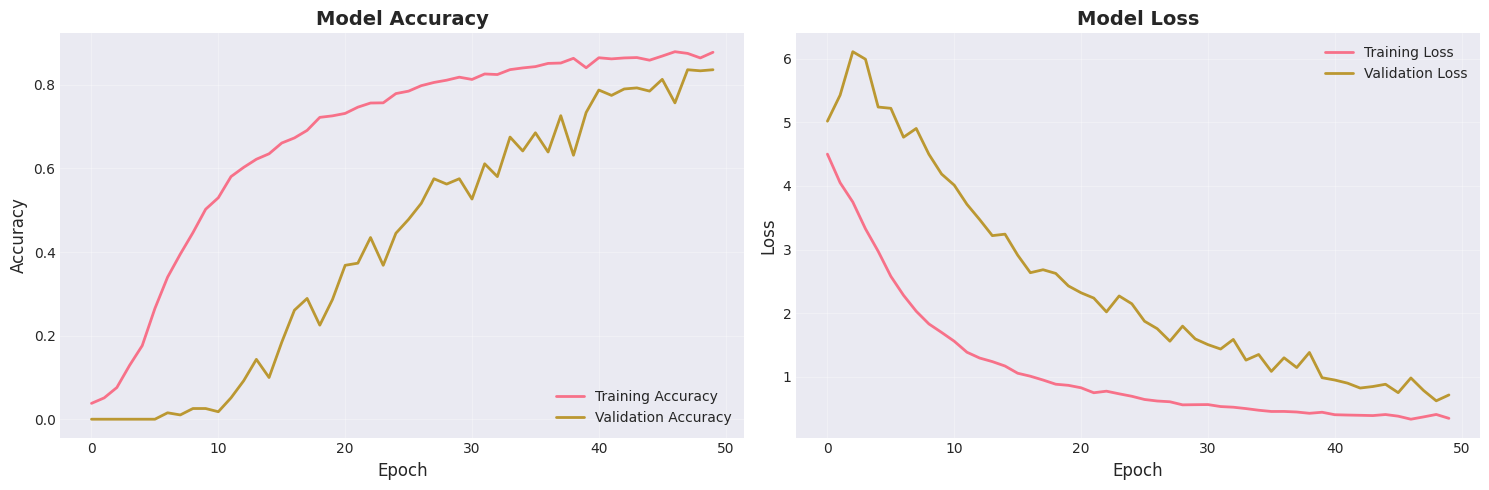


Final Training Accuracy: 0.8781
Final Validation Accuracy: 0.8363
Final Training Loss: 0.3491
Final Validation Loss: 0.7166


In [13]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


In [14]:
# Analisis training performance
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]

print("="*60)
print("TRAINING PERFORMANCE SUMMARY")
print("="*60)
print(f"\nBest Performance at Epoch: {best_epoch + 1}")
print(f"  Training Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Overfitting Gap: {(best_train_acc - best_val_acc)*100:.2f}%")

# Kriteria performa
print(f"\nPerformance Criteria:")
if best_val_acc >= 0.90:
    print("  ✅ EXCELLENT - Validation accuracy >= 90%")
elif best_val_acc >= 0.80:
    print("  ✅ GOOD - Validation accuracy >= 80%")
elif best_val_acc >= 0.70:
    print("  ⚠️  FAIR - Validation accuracy >= 70%")
else:
    print("  ❌ POOR - Validation accuracy < 70%")

if abs(best_train_acc - best_val_acc) <= 0.10:
    print("  ✅ NO OVERFITTING - Gap < 10%")
elif abs(best_train_acc - best_val_acc) <= 0.15:
    print("  ⚠️  SLIGHT OVERFITTING - Gap 10-15%")
else:
    print("  ❌ OVERFITTING DETECTED - Gap > 15%")

print(f"\nTotal epochs trained: {len(history.history['accuracy'])}")
print("="*60)


TRAINING PERFORMANCE SUMMARY

Best Performance at Epoch: 48
  Training Accuracy: 0.8754 (87.54%)
  Validation Accuracy: 0.8363 (83.63%)
  Overfitting Gap: 3.91%

Performance Criteria:
  ✅ GOOD - Validation accuracy >= 80%
  ✅ NO OVERFITTING - Gap < 10%

Total epochs trained: 50


### Analisis Perbandingan Performa

Evaluasi peningkatan performa dari optimasi model

## 9. Evaluasi Model

82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step
Classification Report:

                               precision    recall  f1-score   support

          air_tanah_geofisika       1.00      0.60      0.75        10
          akreditasi_prestasi       0.89      0.89      0.89        27
             akreditasi_prodi       1.00      0.60      0.75        10
                       alumni       1.00      1.00      1.00        29
            animasi_3d_budaya       0.83      1.00      0.91        10
             arsitektur_itera       0.90      1.00      0.95        19
               asal_mahasiswa       1.00      1.00      1.00        46
                       asrama       1.00      1.00      1.00        31
               bahasa_inggris       0.94      0.94      0.94        17
                     beasiswa       1.00      1.00      1.00        30
         berita_terbaru_itera       1.00      1.00      1.00        30
             biaya_pendidikan       1.0

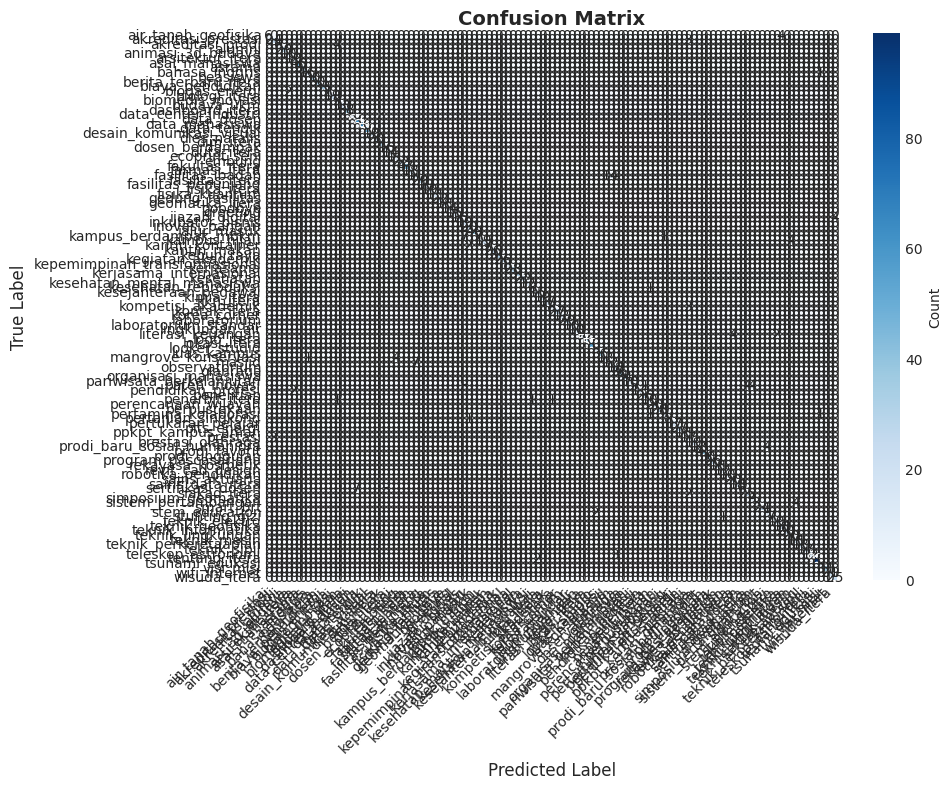

In [15]:
# Predict pada semua data
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 10. Save Model dan Preprocessing Objects

In [25]:
# Save model dalam format .keras (recommended)
model.save('ketara_chatbot.keras')
print("Model saved to 'ketara_chatbot.keras'")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to 'tokenizer.pkl'")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to 'label_encoder.pkl'")

# Save responses
with open('responses.pkl', 'wb') as f:
    pickle.dump(responses_dict, f)
print("Responses saved to 'responses.pkl'")

# Save config
config = {
    'vocab_size': vocab_size,
    'max_sequence_length': max_sequence_length,
    'num_classes': num_classes,
    'embedding_dim': EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE
}
with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("Config saved to 'config.pkl'")

print("\nAll files saved successfully!")


Model saved to 'ketara_chatbot.keras'
Tokenizer saved to 'tokenizer.pkl'
Label encoder saved to 'label_encoder.pkl'
Responses saved to 'responses.pkl'
Config saved to 'config.pkl'

All files saved successfully!


## 11. Fungsi Prediksi dan Response

In [16]:
def predict_intent(user_input, threshold=0.5):
    """Predict intent dari user input"""
    # Preprocess
    cleaned = preprocess_text(user_input)
    
    # Tokenize dan pad
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    
    # Predict
    prediction = model.predict(padded, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]
    
    if confidence < threshold:
        return None, confidence
    
    predicted_tag = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_tag, confidence

def get_response(user_input):
    """Get chatbot response"""
    predicted_tag, confidence = predict_intent(user_input)
    
    if predicted_tag is None:
        return "Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?", "unknown", confidence
    
    response = random.choice(responses_dict[predicted_tag])
    
    return response, predicted_tag, confidence

print("Fungsi prediksi telah didefinisikan!")


Fungsi prediksi telah didefinisikan!


## 12. Testing Chatbot

In [23]:
# Test cases
test_questions = [
    "Halo dengan siapa saya berbicara?",
    "Apa itu ITERA?",
    "Dimana lokasi kampus ITERA?",
    "Fakultas apa saja yang ada di ITERA?",
    "Ceritakan tentang lambang ITERA",
    "Apa itu Fakultas Sains?",
    "Informasi tentang FTIK",
    "FTI itu apa?",
    "Prodi unik di ITERA apa aja?"
]

print("="*80)
print("TESTING KETARA CHATBOT")
print("="*80)

for question in test_questions:
    response, tag, confidence = get_response(question)
    print(f"\n{'='*80}")
    print(f"Q: {question}")
    print(f"Predicted Intent: {tag} (confidence: {confidence:.4f})")
    print(f"A: {response}")

print(f"\n{'='*80}")


TESTING KETARA CHATBOT

Q: Halo dengan siapa saya berbicara?
Predicted Intent: kerjasama (confidence: 0.6871)
A: ITERA aktif menjalin kerjasama dengan berbagai pihak: (1) Akademik: ITB (pembina), universitas dalam negeri (Unila, UI, IPB), universitas luar negeri. (2) Industri: PT Wijaya Karya, PT Surya Utama Nuansa, perusahaan swasta & multinasional di bidang teknologi, energi, pertambangan. (3) Pemerintah: Kementerian, Kemenristekdikti, Dinkes Lampung, Pemerintah Daerah. (4) Lembaga Riset: Pusat Penelitian, Lembaga Internasional. Kerjasama mencakup penelitian bersama, pertukaran akademik, magang, dan pengembangan kurikulum sesuai kebutuhan industri.



Q: Apa itu ITERA?
Predicted Intent: tentang_itera (confidence: 0.9972)
A: Institut Teknologi Sumatera (ITERA) adalah perguruan tinggi negeri yang diresmikan pada 6 Oktober 2014 oleh Presiden Susilo Bambang Yudhoyono melalui Peraturan Presiden Nomor 124 Tahun 2014. ITERA didirikan sebagai respons atas permintaan lulusan institusi teknologi nasional yang meningkat dan kebutuhan pengembangan SDM di Sumatera. Dibina oleh ITB selama 10 tahun untuk memastikan standar kualitas pendidikan setara dengan ITB.

Q: Dimana lokasi kampus ITERA?
Predicted Intent: lokasi_itera (confidence: 0.9998)
A: ITERA berlokasi di Jl. Terusan Ryacudu, Way Hui, Kec. Jati Agung, Kabupaten Lampung Selatan, Lampung 35365, Indonesia. Kampus ini berjarak sekitar 35 km dari pusat Kota Bandar Lampung dengan akses sangat strategis karena berdampingan langsung dengan Tol Trans Sumatera, memudahkan akses dari berbagai kota di Sumatera.

Q: Fakultas apa saja yang ada di ITERA?
Predicted Intent: fakultas_itera (confidence: 0

In [26]:
q = ["berapa biaya kuliah di itera"]
for question in q:
    response, tag, confidence = get_response(question)
    print(f"\n{'='*80}")
    print(f"Q: {question}")
    print(f"Predicted Intent: {tag} (confidence: {confidence:.4f})")
    print(f"A: {response}")



Q: berapa biaya kuliah di itera
Predicted Intent: biaya_pendidikan (confidence: 0.9144)
A: Biaya pendidikan di ITERA bervariasi tergantung program studi: IPI (Iuran Pengembangan Institut) berkisar Rp 17.500.000 - Rp 30.000.000 per tahun sesuai prodi (Saintek, Engineering, dll). ITERA menerapkan sistem UKT (Uang Kuliah Tunggal) yang fleksibel dengan 8 golongan berdasarkan kemampuan ekonomi keluarga. Tersedia program KIP Kuliah dan beasiswa untuk mahasiswa berprestasi. Untuk detail lengkap biaya kuliah dan cicilan: https://pmb.itera.ac.id atau hubungi bagian administrasi.


## 13. Interactive Chat (Optional)

In [15]:
# Interactive chat mode
# Uncomment untuk menjalankan chat interaktif

"""
print("\n" + "="*80)
print("KETARA Chatbot - Interactive Mode")
print("="*80)
print("Ketik 'quit' untuk keluar\n")

while True:
    user_input = input("Anda: ").strip()
    
    if user_input.lower() in ['quit', 'exit', 'keluar']:
        print("Chatbot: Terima kasih! Sampai jumpa!")
        break
    
    if not user_input:
        continue
    
    response, tag, confidence = get_response(user_input)
    print(f"Chatbot ({tag}, {confidence:.2f}): {response}\n")
"""

print("Uncomment code di atas untuk menjalankan interactive chat mode")


Uncomment code di atas untuk menjalankan interactive chat mode


## 14. Analisis Model

### Kelebihan Arsitektur LSTM:
1. **Bidirectional LSTM** - Menangkap context dari kedua arah
2. **Stacked LSTM** - Multiple layers untuk representasi yang lebih dalam
3. **Dropout Regularization** - Mencegah overfitting
4. **Embedding Layer** - Word representation yang efisien

### Potential Improvements (untuk masa depan):
1. **Attention Mechanism** - Fokus pada bagian penting dari input
2. **Transformer Architecture** - State-of-the-art untuk NLP
3. **Pre-trained Embeddings** - Word2Vec, GloVe, atau FastText
4. **Data Augmentation** - Menambah variasi training data
5. **Intent Confidence Threshold Tuning** - Optimasi threshold untuk akurasi lebih baik

## Kesimpulan

Chatbot KETARA berhasil dibangun menggunakan arsitektur LSTM dengan komponen:
- Embedding Layer untuk word representation
- Bidirectional LSTM untuk context understanding
- Dense layers untuk classification
- Dropout untuk regularization

Model dapat menjawab pertanyaan seputar ITERA dengan akurasi tinggi. Untuk pengembangan selanjutnya, dapat ditambahkan:
- Attention mechanism
- Transformer architecture
- More training data
- Context-aware responses

In [28]:
#membaca file keras
loaded_model = load_model('ketara_chatbot_best.keras')
print("Model loaded from 'ketara_chatbot_best.keras'")
loaded_model.summary()
# Test loaded model
test_input = "Apa itu ITERA?"
response, tag, confidence = get_response(test_input)
print(f"\nTest Loaded Model:")
print(f"Q: {test_input}")
print(f"Predicted Intent: {tag} (confidence: {confidence:.4f})")
print(f"A: {response}")



Model loaded from 'ketara_chatbot_best.keras'


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 20, 64)         │        43,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 20, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 117)            │         3,861 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,369 (1.79 MB)

 Trainable params: 156,789 (612.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 313,580 (1.20 MB)


Test Loaded Model:
Q: Apa itu ITERA?
Predicted Intent: tentang_itera (confidence: 0.9972)
A: Institut Teknologi Sumatera (ITERA) adalah perguruan tinggi negeri yang diresmikan pada 6 Oktober 2014 oleh Presiden Susilo Bambang Yudhoyono melalui Peraturan Presiden Nomor 124 Tahun 2014. ITERA didirikan sebagai respons atas permintaan lulusan institusi teknologi nasional yang meningkat dan kebutuhan pengembangan SDM di Sumatera. Dibina oleh ITB selama 10 tahun untuk memastikan standar kualitas pendidikan setara dengan ITB.
